In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pulse2percept as p2p
%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2017-10-31 19:47:13,535 [pulse2percept] [INFO] Welcome to pulse2percept


In [3]:
def naivecascade(stim, model, maxR3=99.8873446571, skip_i=0):

    tmp_chargeacc = 0
    tmp_ca = 0
    tmp_cl = 0
    tmp_R1 = 0
    tmp_R2 = 0
    tmp_R3norm = 0
    tmp_R4a = [0, 0, 0, 0]

    i = 0
    # skip_i = 0
    newi = 0
    count = 0
    
    t = np.arange(0, stim.duration, stim.tsample)

    out_t = []
    out_R3 = []
    out_R4 = []

    dR1min = 0.0005

    while i < len(t):
        count += 1
        while np.abs(stim.data[newi - 1] - tmp_R1) < dR1min / (newi - i + 1) and newi < len(t) - 1 and newi - i < skip_i:
            newi += 1
        newi += 1
        dt = tsample * (newi - i)

        i = newi
        newi = i
        if len(out_t) > 0:
            out_t.append(out_t[-1] + dt)
        else:
            out_t.append(dt)

        # R1
        tmp_R1 += dt * (-stim.data[i - 1] - tmp_R1) / model.tau1

        # leaky integrated charge accumulation
        tmp_chargeacc += dt * np.maximum(stim.data[i - 1], 0)
        tmp_ca += dt * (tmp_chargeacc - tmp_ca) / model.tau2
        tmp_R3 = np.maximum(tmp_R1 - model.eps * tmp_ca, 0)

        # nonlinearity
        tmp_R3norm = tmp_R3 / maxR3
        sc_fac = model.asymptote / (1.0 + np.exp(-(maxR3 - model.shift) / model.slope))
        tmp_R3b = tmp_R3norm * sc_fac

        # R4: R3 passed through a cascade of 3 leaky integrators
        tmp_R4a[0] = tmp_R3b
        for j in range(3):
            dR4a = dt * (tmp_R4a[j] - tmp_R4a[j + 1]) / model.tau3
            tmp_R4a[j + 1] += dR4a

        out_R3.append(tmp_R3)
        out_R4.append(tmp_R4a[-1])
        
    return out_t, out_R4

In [4]:
%%cython

import numpy as np
cimport numpy as np
import scipy.special as ss
import cython

cdef inline float float_max(float a, float b): return a if a >= b else b
DTYPE = np.float
ctypedef np.float_t DTYPE_t

def cythoncascade(stim, model, maxR3=99.8873446571, skip_i=0):
    cdef float tmp_chargeacc = 0
    cdef float tmp_ca = 0
    cdef float tmp_cl = 0
    cdef float tmp_R1 = 0
    cdef float tmp_R2 = 0
    cdef float tmp_R3norm = 0
    cdef float dt = stim.tsample
    cdef np.ndarray[DTYPE_t] stimdata = stim.data
    
    cdef float tmp_R3 = 0
    cdef float sc_fac = 0
    
    tmp_R4a = [0, 0, 0, 0]
    cdef np.ndarray[DTYPE_t] out_t = np.arange(0, stim.duration, stim.tsample, dtype=DTYPE)
    cdef np.ndarray[DTYPE_t] out_R4 = np.zeros_like(out_t, dtype=DTYPE)
    
    cdef float tau1 = model.tau1
    cdef float tau2 = model.tau2
    cdef float tau3 = model.tau3
    cdef float asymptote = model.asymptote
    cdef float shift = model.shift
    cdef float slope = model.slope

    for i in range(len(out_t)):
        tmp_R1 += dt * (-stimdata[i] - tmp_R1) / tau1

        # leaky integrated charge accumulation
        tmp_chargeacc += dt * float_max(stimdata[i], 0)
        tmp_ca += dt * (tmp_chargeacc - tmp_ca) / tau2
        tmp_R3 = float_max(tmp_R1 - model.eps * tmp_ca, 0)

        # nonlinearity
        sc_fac = asymptote * ss.expit((maxR3 - shift) / slope)
        
        # R4: R3 passed through a cascade of 3 leaky integrators
        tmp_R4a[0] = tmp_R3b = tmp_R3 / maxR3 * sc_fac
        for j in range(3):
            dR4a = dt * (tmp_R4a[j] - tmp_R4a[j + 1]) / tau3
            tmp_R4a[j + 1] += dR4a

        out_R4[i] = tmp_R4a[-1]
        
    return out_t, out_R4

### Model output

In [5]:
tsample = 0.005 / 1000
model = p2p.retina.Nanduri2012(tsample=tsample)
stim = p2p.stimuli.PulseTrain(tsample, freq=20, amp=150, pulse_dur=0.45 / 1000, dur=0.5)
layers = ['GCL']
use_jit = True
nanduri_out = model.model_cascade(np.array([1, 1]).reshape((2, 1)), stim.data, layers, use_jit)
nanduri_t = tsample * np.arange(len(nanduri_out.data))

In [6]:
naive_t, naive_out = naivecascade(stim, model)
cython_t, cython_out = cythoncascade(stim, model)

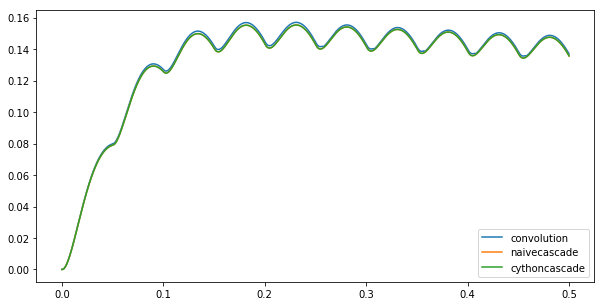

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(nanduri_t, nanduri_out.data, label='convolution')
plt.plot(naive_t, naive_out, label='naivecascade')
plt.plot(cython_t, cython_out, label='cythoncascade')
plt.legend(loc='lower right')

### Accuracy

In [8]:
np.allclose(naive_out, nanduri_out.data, atol=5e-3)

True

In [9]:
np.allclose(cython_out, nanduri_out.data, atol=5e-3)

True

### Speed

In [10]:
%timeit out = model.model_cascade(np.array([1, 1]).reshape((2, 1)), stim.data, layers, use_jit)

572 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit out_R4 = naivecascade(stim, model)

849 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit out_R4 = cythoncascade(stim, model)

153 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
